# Brain Tumor MRI Classification – RNN

This notebook trains a **Recurrent Neural Network (RNN)** on the Brain Tumor MRI Dataset – Merged (4 classes).
- Shared preprocessing: grayscale, resize to 64×64, normalize
- Train/val split with stratification
- Metrics: Accuracy, F1-score, Confusion Matrix; plus learning curves

> Set `DATA_DIR` to your dataset root (with subfolders: `glioma/`, `meningioma/`, `pituitary/`, `no_tumor/`).

In [ ]:
# --- Setup & Imports (TensorFlow/Keras) ---
import os, pathlib, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

print("TensorFlow:", tf.__version__)
DATA_DIR = "../data"  # <-- change if needed
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 42

# --- Load image paths and labels from folder structure ---
data_root = pathlib.Path(DATA_DIR)
classes = ["glioma", "meningioma", "pituitary", "notumor"]
class_to_idx = {c:i for i,c in enumerate(classes)}

image_paths, labels = [], []
image_sizes = []  # Track original image sizes

for c in classes:
    class_dir = data_root / c
    if not class_dir.exists():
        raise FileNotFoundError(f"Missing folder: {class_dir}. Create subfolders for each class and add images.")
    for p in class_dir.glob("*"):
        if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
            image_paths.append(str(p))
            labels.append(class_to_idx[c])
            # Get original image size
            try:
                with Image.open(p) as img:
                    image_sizes.append(img.size)  # (width, height)
            except:
                image_sizes.append((0, 0))

print(f"Found {len(image_paths)} images across {len(classes)} classes.")

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)
print("Train:", len(X_train), " Val:", len(X_val))

TensorFlow: 2.16.1
Found 13351 images across 4 classes.
Train: 10680  Val: 2671
Found 13351 images across 4 classes.
Train: 10680  Val: 2671


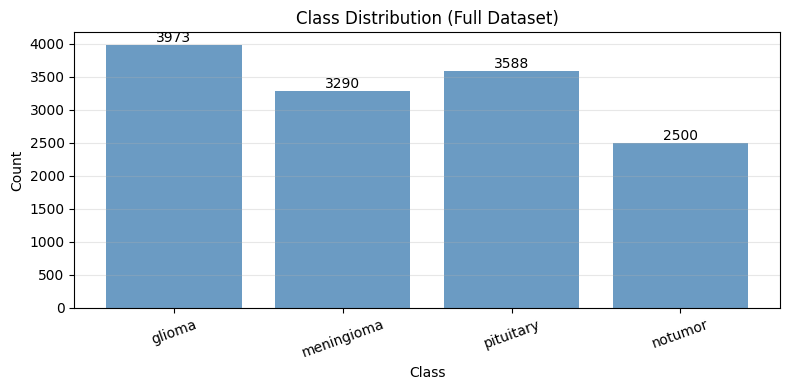

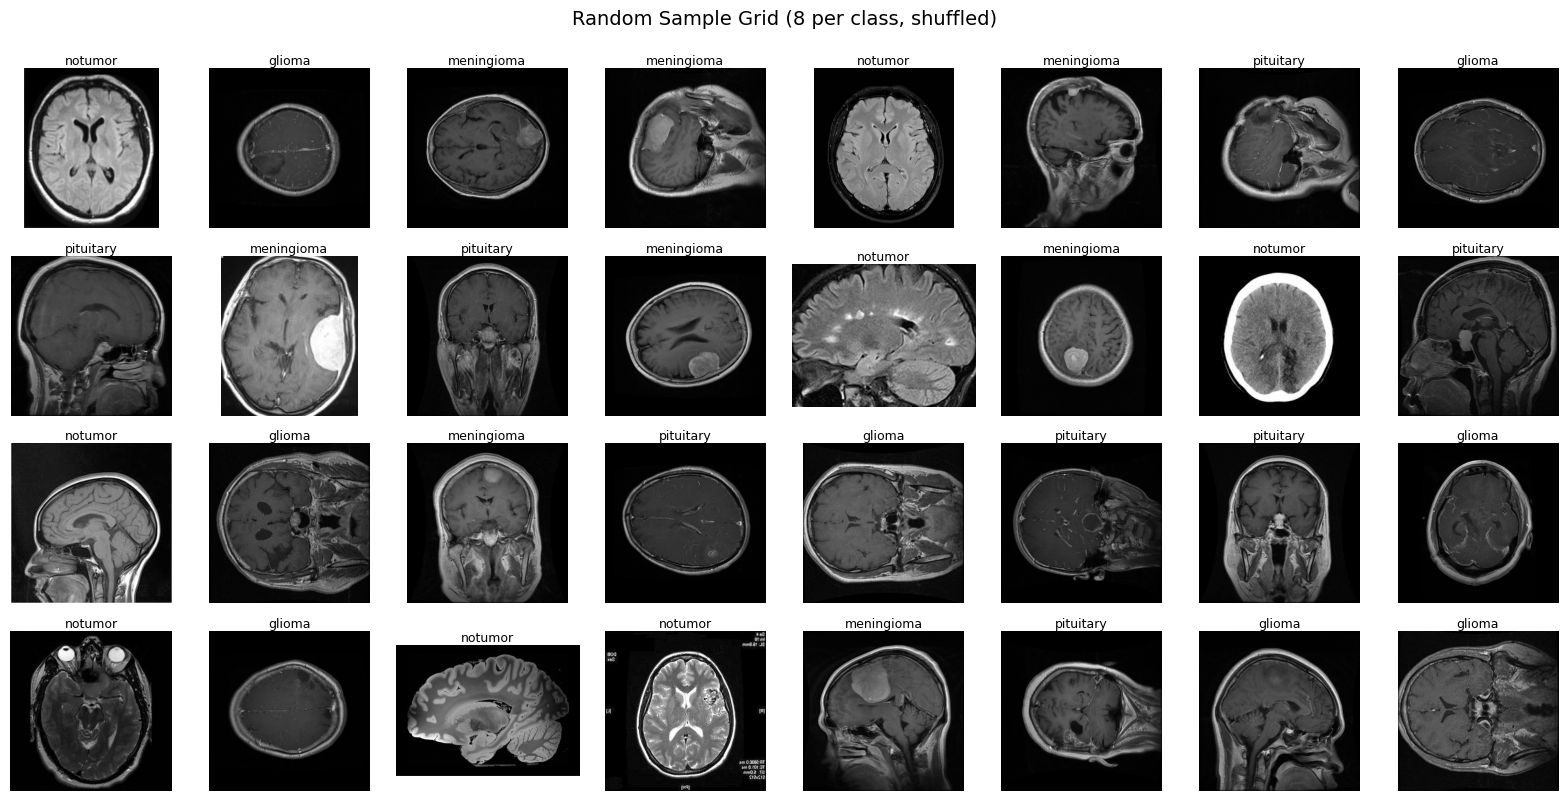

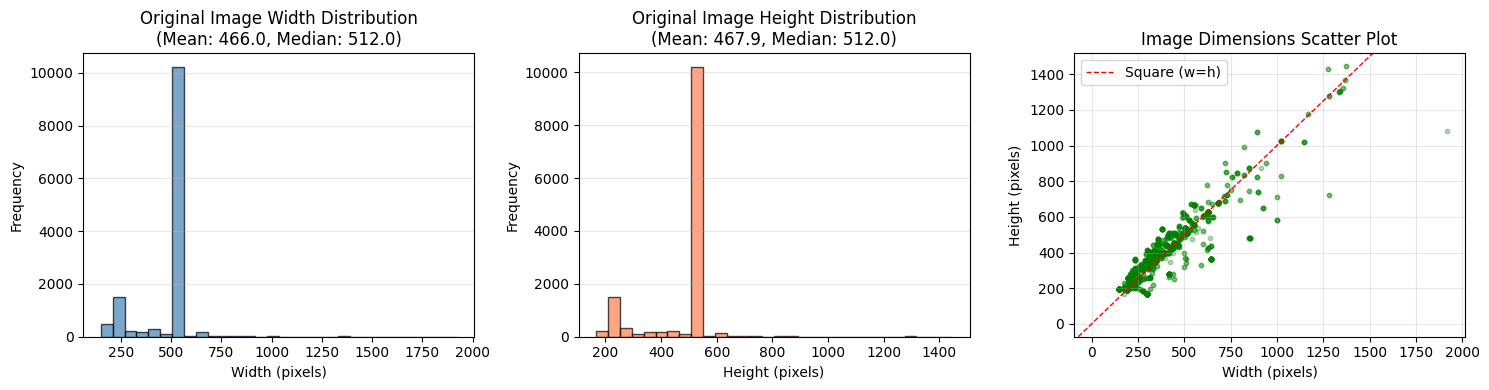


Original image size statistics:
  Width:  min=150, max=1920, mean=466.0
  Height: min=167, max=1446, mean=467.9
  Target resize: (64, 64)


In [11]:
# Dataset visuals
from collections import Counter

# 1. Bar chart of class counts
cnt = Counter(labels)
plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(classes)), [cnt[i] for i in range(len(classes))], color='steelblue', alpha=0.8)
plt.xticks(range(len(classes)), classes, rotation=20)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (Full Dataset)")
plt.grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# 2. 4×8 grid of random images (2 per class, shuffled)
n_per_class = 8
samples_per_class = []

# Collect 8 random samples per class
for class_idx in range(len(classes)):
    class_indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    random.seed(SEED)
    selected = random.sample(class_indices, min(n_per_class, len(class_indices)))
    samples_per_class.extend([(image_paths[i], labels[i]) for i in selected])

# Shuffle the collected samples
random.seed(SEED)
random.shuffle(samples_per_class)

# Display in 4×8 grid
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
axes = axes.flatten()

for idx, (img_path, lbl) in enumerate(samples_per_class[:32]):  # 4×8 = 32 images
    try:
        img = Image.open(img_path).convert('L')
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(classes[lbl], fontsize=9, pad=2)
        axes[idx].axis('off')
    except Exception as e:
        axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[idx].axis('off')

# Hide any unused subplots
for idx in range(len(samples_per_class), 32):
    axes[idx].axis('off')

plt.suptitle("Random Sample Grid (8 per class, shuffled)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# 3. Image size distribution (before resizing)
widths = [sz[0] for sz in image_sizes if sz[0] > 0]
heights = [sz[1] for sz in image_sizes if sz[1] > 0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Width distribution
axes[0].hist(widths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Original Image Width Distribution\n(Mean: {np.mean(widths):.1f}, Median: {np.median(widths):.1f})')
axes[0].grid(axis='y', alpha=0.3)

# Height distribution
axes[1].hist(heights, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Original Image Height Distribution\n(Mean: {np.mean(heights):.1f}, Median: {np.median(heights):.1f})')
axes[1].grid(axis='y', alpha=0.3)

# Scatter plot of width vs height
axes[2].scatter(widths, heights, alpha=0.3, s=10, c='green')
axes[2].set_xlabel('Width (pixels)')
axes[2].set_ylabel('Height (pixels)')
axes[2].set_title('Image Dimensions Scatter Plot')
axes[2].grid(True, alpha=0.3)
axes[2].axline((0, 0), slope=1, color='red', linestyle='--', linewidth=1, label='Square (w=h)')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nOriginal image size statistics:")
print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
print(f"  Target resize: {IMG_SIZE}")

In [12]:
# --- TF data pipeline ---
AUTOTUNE = tf.data.AUTOTUNE

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img.set_shape([None, None, 1])  # Set shape explicitly
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)/255.0
    return img, tf.cast(label, tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train), seed=SEED)
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [13]:
# Data augmentation (applied during training only)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

In [ ]:
# We reshape the image (64,64,1) -> (64,64) and feed rows as time steps.
inputs = layers.Input(shape=(*IMG_SIZE, 1))
x = data_augmentation(inputs)

# Reshape: (64, 64, 1) -> (64, 64) - treat rows as time steps, columns as features
x = layers.Reshape((IMG_SIZE[0], IMG_SIZE[1]))(x)

# 1D Convolution: Extract local patterns along each row
x = layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2)(x)  # (32, 64)

# Bidirectional LSTM: Capture temporal dependencies in both directions
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
x = layers.Dropout(0.5)(x)

# Classification head
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs, name='RNN_Conv1D_BiLSTM')
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "RNN_Conv1D_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,140 (918.52 KB)

 Trainable params: 235,012 (918.02 KB)

 Non-trainable params: 128 (512.00 B)

333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4675 - loss: 1.1670
Epoch 1: val_accuracy improved from None to 0.59528, saving model to ..\artifacts\rnn\best_model.h5

Epoch 1: val_accuracy improved from None to 0.59528, saving model to ..\artifacts\rnn\best_model.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.5258 - loss: 1.0711 - val_accuracy: 0.5953 - val_loss: 0.9707 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Restoring model weights from the end of the best epoch: 1.


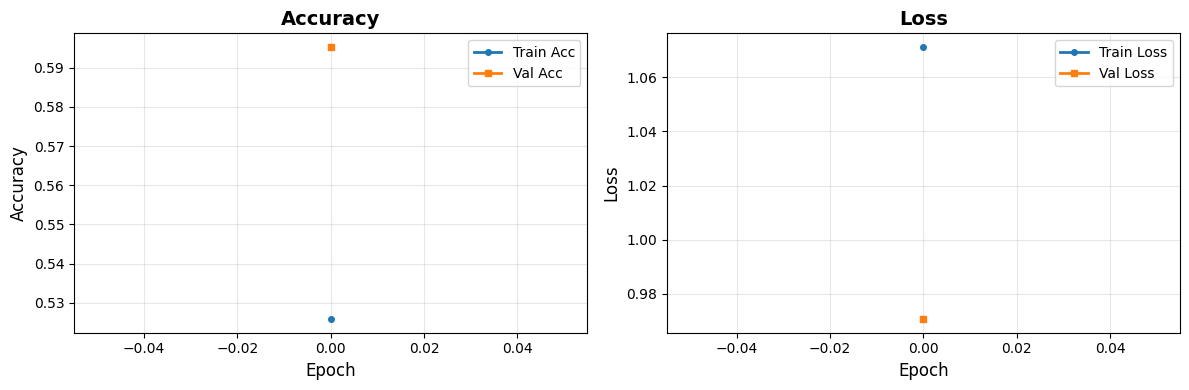

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


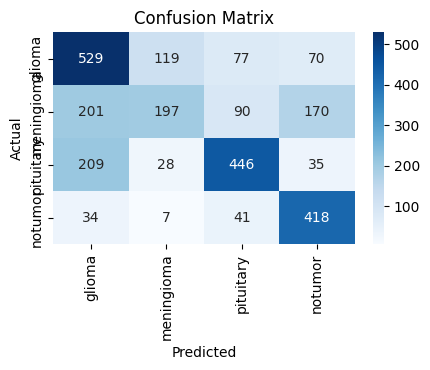

              precision    recall  f1-score   support

      glioma       0.54      0.67      0.60       795
  meningioma       0.56      0.30      0.39       658
   pituitary       0.68      0.62      0.65       718
     notumor       0.60      0.84      0.70       500

    accuracy                           0.60      2671
   macro avg       0.60      0.61      0.58      2671
weighted avg       0.60      0.60      0.58      2671

Weighted F1: 0.5802554696322119


In [ ]:
# --- Train with callbacks ---
EPOCHS = 30

# Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(artifacts_dir / 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# --- Learning curves ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(history.history["accuracy"], label="Train Acc", linewidth=2, marker='o', markersize=4)
axes[0].plot(history.history["val_accuracy"], label="Val Acc", linewidth=2, marker='s', markersize=4)
axes[0].set_title("Accuracy", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Accuracy", fontsize=12)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history["loss"], label="Train Loss", linewidth=2, marker='o', markersize=4)
axes[1].plot(history.history["val_loss"], label="Val Loss", linewidth=2, marker='s', markersize=4)
axes[1].set_title("Loss", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Loss", fontsize=12)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Evaluation ---
y_true = np.array(y_val)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4.5,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix"); plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

print(classification_report(y_true, y_pred, target_names=classes))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))


Total wrong predictions: 1081 / 2671


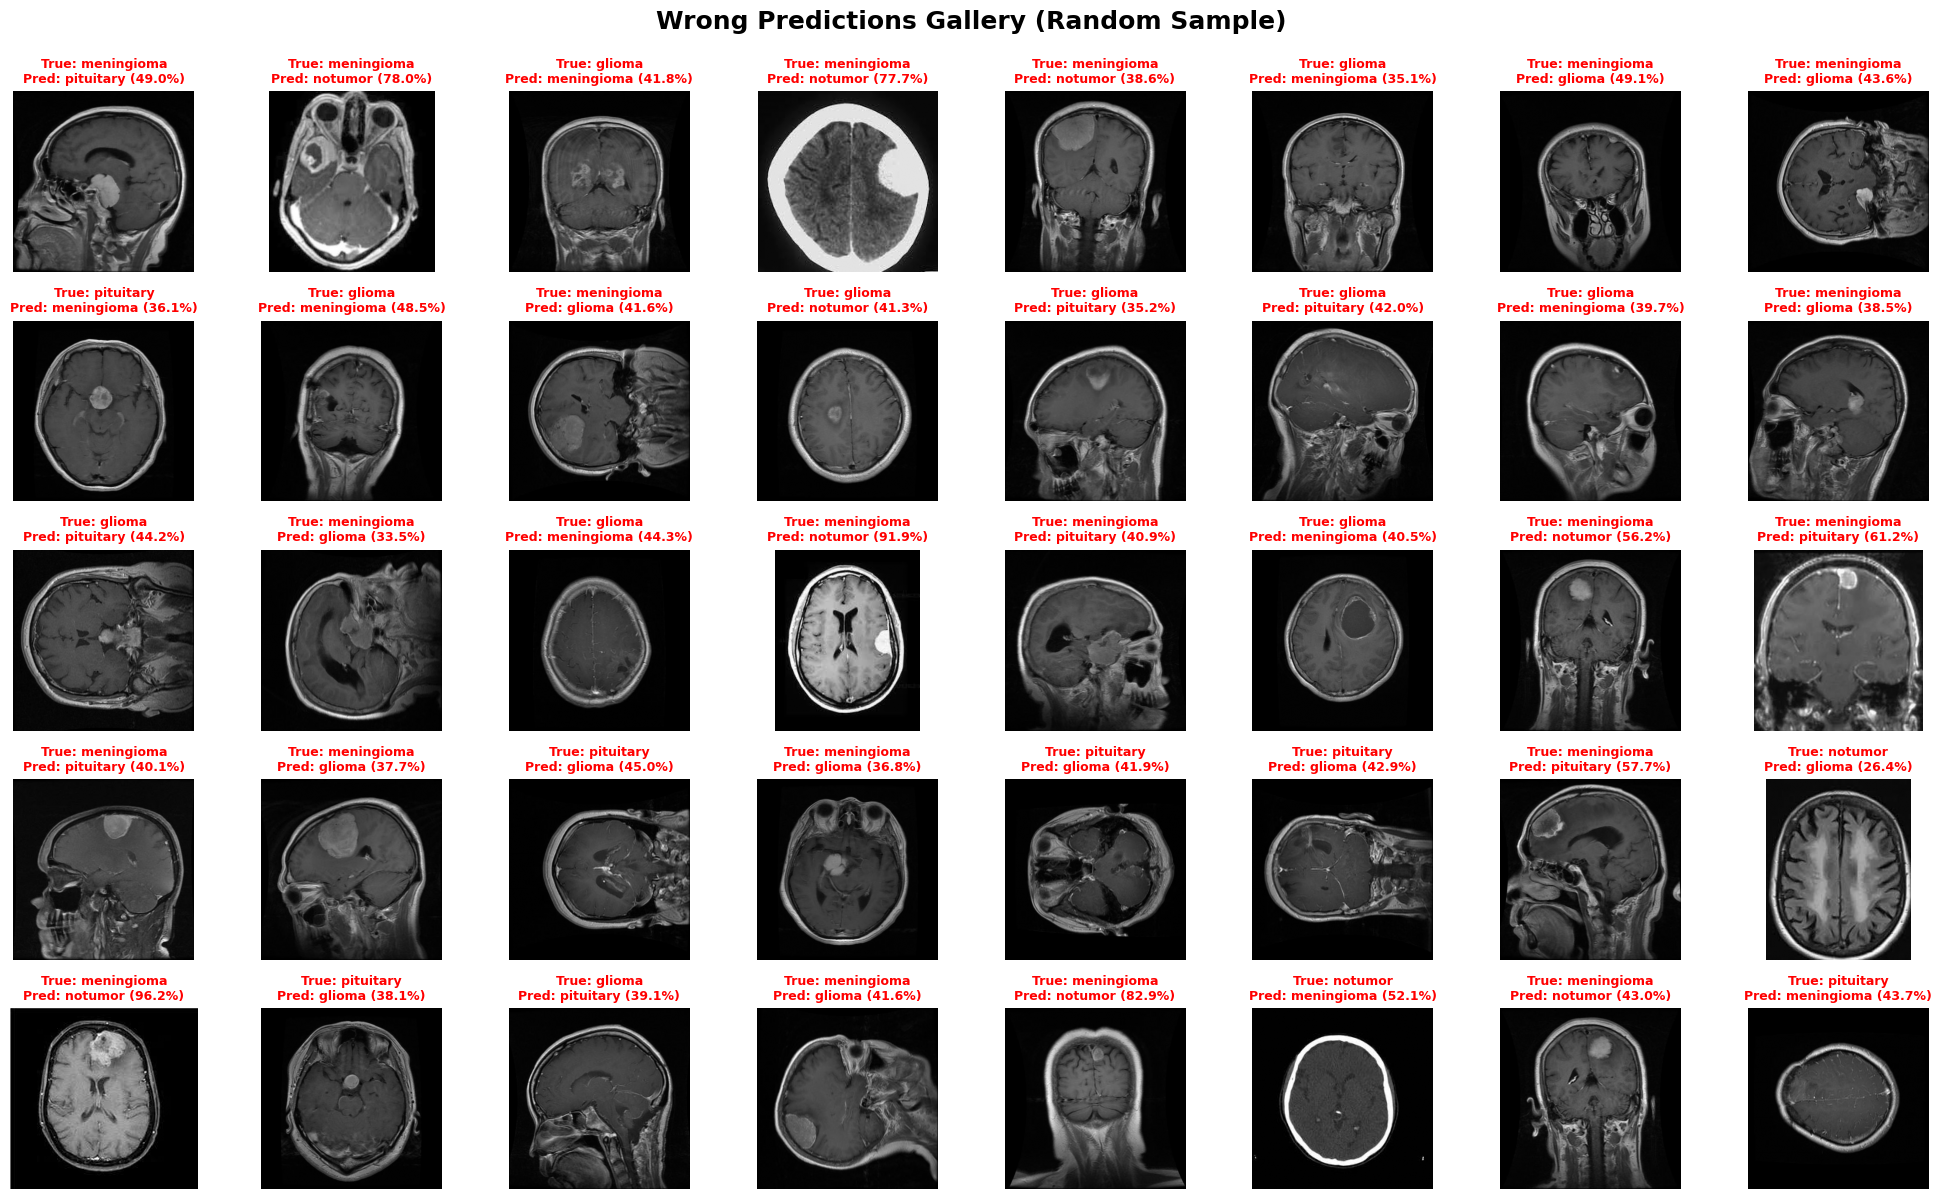

✓ Wrong predictions gallery saved to ..\artifacts\rnn\wrong_predictions.png


In [18]:
# =============================
# Wrong Predictions Gallery (5×8 grid = 40 images)
# =============================

# Identify all wrong predictions
wrong_indices = np.where(y_pred != y_true)[0]
print(f"\nTotal wrong predictions: {len(wrong_indices)} / {len(y_true)}")

# Sample up to 40 random wrong predictions
num_samples = min(40, len(wrong_indices))
sampled_wrong = np.random.choice(wrong_indices, size=num_samples, replace=False)

fig, axes = plt.subplots(5, 8, figsize=(20, 12))
fig.suptitle('Wrong Predictions Gallery (Random Sample)', fontsize=18, fontweight='bold', y=0.995)

for idx, ax in enumerate(axes.flat):
    if idx < len(sampled_wrong):
        i = sampled_wrong[idx]
        img_path = X_val[i]
        img = Image.open(img_path).convert('L')
        
        true_class = classes[y_true[i]]
        pred_class = classes[y_pred[i]]
        confidence = y_pred_probs[i, y_pred[i]] * 100
        
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(
            f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)',
            fontsize=9,
            color='red',
            fontweight='bold'
        )
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig(artifacts_dir / 'wrong_predictions.png', dpi=120, bbox_inches='tight')
plt.show()

print(f"✓ Wrong predictions gallery saved to {artifacts_dir / 'wrong_predictions.png'}")

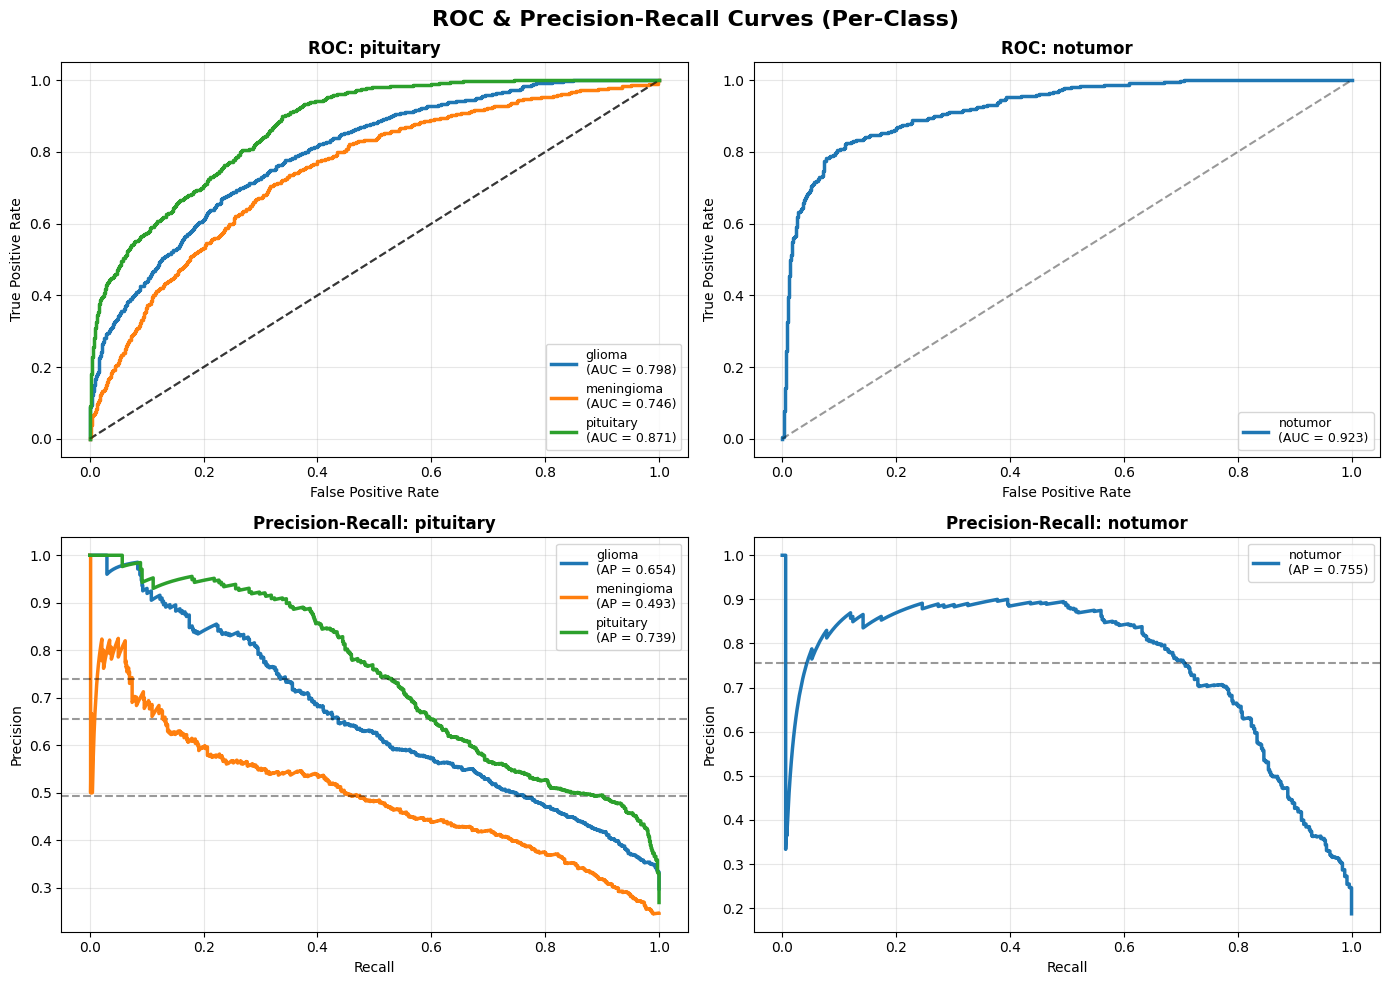

✓ ROC & PR curves saved to ..\artifacts\rnn\roc_pr_curves.png
✓ Curve data saved to ..\artifacts\rnn\roc_pr_curves.pkl


In [19]:
# =============================
# ROC & Precision-Recall Curves (Per-Class)
# =============================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class ROC/PR
y_true_bin = label_binarize(y_true, classes=range(4))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('ROC & Precision-Recall Curves (Per-Class)', fontsize=16, fontweight='bold')

roc_data = {}
pr_data = {}

for i, cls in enumerate(classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_data[cls] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])
    pr_data[cls] = {'precision': precision, 'recall': recall, 'avg_precision': avg_precision}
    
    # Plot ROC
    ax_roc = axes[0, i // 2] if i < 2 else axes[0, i % 2]
    ax_roc.plot(fpr, tpr, linewidth=2.5, label=f'{cls}\n(AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.4)
    ax_roc.set_title(f'ROC: {cls}', fontsize=12, fontweight='bold')
    ax_roc.set_xlabel('False Positive Rate', fontsize=10)
    ax_roc.set_ylabel('True Positive Rate', fontsize=10)
    ax_roc.legend(loc='lower right', fontsize=9)
    ax_roc.grid(True, alpha=0.3)
    
    # Plot PR
    ax_pr = axes[1, i // 2] if i < 2 else axes[1, i % 2]
    ax_pr.plot(recall, precision, linewidth=2.5, label=f'{cls}\n(AP = {avg_precision:.3f})')
    ax_pr.axhline(y=avg_precision, color='k', linestyle='--', linewidth=1.5, alpha=0.4)
    ax_pr.set_title(f'Precision-Recall: {cls}', fontsize=12, fontweight='bold')
    ax_pr.set_xlabel('Recall', fontsize=10)
    ax_pr.set_ylabel('Precision', fontsize=10)
    ax_pr.legend(loc='best', fontsize=9)
    ax_pr.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(artifacts_dir / 'roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Save curve data
import pickle
with open(artifacts_dir / 'roc_pr_curves.pkl', 'wb') as f:
    pickle.dump({'roc': roc_data, 'pr': pr_data}, f)

print(f"✓ ROC & PR curves saved to {artifacts_dir / 'roc_pr_curves.png'}")
print(f"✓ Curve data saved to {artifacts_dir / 'roc_pr_curves.pkl'}")

In [20]:
# Save artifacts
import json
import pickle
import pandas as pd
from pathlib import Path
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# 1. Ensure artifacts/<model_name>/ exists
model_name = "rnn"
artifacts_dir = Path(f"../artifacts/{model_name}")
artifacts_dir.mkdir(parents=True, exist_ok=True)
print(f"Artifacts directory: {artifacts_dir}")

# 2. Compute classification metrics
y_true = np.array(y_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get classification report as dict
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")

metrics = {
    "accuracy": float(acc),
    "macro_f1": float(macro_f1),
    "weighted_f1": float(weighted_f1),
    "classification_report": report_dict
}

# 3. Save metrics.json
with open(artifacts_dir / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print(f"✓ Saved metrics.json")

# Save history.csv
history_df = pd.DataFrame(history.history)
history_df.to_csv(artifacts_dir / "history.csv", index=False)
print(f"✓ Saved history.csv")

# Save confusion matrix
np.save(artifacts_dir / "cm.npy", cm)
print(f"✓ Saved cm.npy")

# 4. Build one-vs-rest ROC and PR curves for each class
n_classes = len(classes)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

roc_curves = {}
pr_curves = {}

for i, class_name in enumerate(classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves[class_name] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "auc": float(roc_auc)}
    
    # PR curve
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
    pr_curves[class_name] = {"precision": precision.tolist(), "recall": recall.tolist()}

# Pickle ROC and PR curves
with open(artifacts_dir / "roc_pr_curves.pkl", "wb") as f:
    pickle.dump({"roc": roc_curves, "pr": pr_curves}, f)
print(f"✓ Saved roc_pr_curves.pkl")

# 5. Collect top-40 mistakes with lowest max softmax (or highest wrong prob)
# Get max softmax probability and identify mistakes
max_probs = np.max(y_pred_probs, axis=1)
mistakes_mask = (y_pred != y_true)
mistake_indices = np.where(mistakes_mask)[0]

# Sort mistakes by lowest max softmax (most uncertain)
sorted_mistake_idx = mistake_indices[np.argsort(max_probs[mistake_indices])]

# Take top-40 (or fewer if less mistakes)
top_mistakes = sorted_mistake_idx[:40]

# Create error examples dataframe
error_examples = []
for idx in top_mistakes:
    wrong_prob = y_pred_probs[idx, y_pred[idx]]
    correct_prob = y_pred_probs[idx, y_true[idx]]
    error_examples.append({
        "val_index": int(idx),
        "image_path": X_val[idx],
        "true_label": classes[y_true[idx]],
        "predicted_label": classes[y_pred[idx]],
        "max_softmax": float(max_probs[idx]),
        "predicted_prob": float(wrong_prob),
        "true_class_prob": float(correct_prob)
    })

errors_df = pd.DataFrame(error_examples)
errors_df.to_csv(artifacts_dir / "example_errors.csv", index=False)
print(f"✓ Saved example_errors.csv ({len(errors_df)} mistakes)")

print(f"\n✅ All artifacts saved to {artifacts_dir}/")
print(f"   - metrics.json")
print(f"   - history.csv")
print(f"   - cm.npy")
print(f"   - roc_pr_curves.pkl")
print(f"   - example_errors.csv")

Artifacts directory: ..\artifacts\rnn
✓ Saved metrics.json
✓ Saved history.csv
✓ Saved cm.npy
✓ Saved roc_pr_curves.pkl
✓ Saved example_errors.csv (40 mistakes)

✅ All artifacts saved to ..\artifacts\rnn/
   - metrics.json
   - history.csv
   - cm.npy
   - roc_pr_curves.pkl
   - example_errors.csv
